# Predictive Keyboard

## Recurrent Neural Network
RNN are simple Neural Network with hidden layers more than one. RNN models provide a way to not only examine the current input but also provide one step back

## LSTMs 
There are two problems with RNNS-Vanishing and exploding gradient. In RNNs the gradient signal can be multiplied a large number of times by the weight matrix. Thus, the magnitude of the weights of the transition matrix can play an important role.

### Gradients
If the weights in the martrix are small, the gradient signal becomes smaller at every training step, thus learning becomes very slow or completely stops. This is called Vanishing gradient.

## Setup
Import all required modules

In [6]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline
sns.set(style='whitegrid',palette='muted', font_scale=1.5)
rcParams['figure.figsize']=12 , 5


## Loading the Data
We will use Friedrich Nietzsche’s Beyond Good and Evil as a training corpus for our model.

In [7]:
path='nietzsche.txt'
text=open(path).read().lower() #converting all text to lowercase
print('Corpus length: ',len(text))

Corpus length:  381443


## Preprocessing
Let's find all unique chars in the corpus and create char to index and index to char maps:

In [8]:
chars = sorted(list(set(text)))
char_indices = dict((c,i) for i, c in enumerate(chars))
indices_char= dict((i ,c) for i, c in enumerate(chars))
print('unique chars: ', len(chars))

unique chars:  52


Next, let's cut the corpus into chunks of 40 characters, spacing the sequences by 3 characters. Additionally, we will store the next character(the one we need to predict) for every sequence:

In [9]:
SEQUENCE_LENGTH=40
step=3
sentences=[]
next_chars=[]
for i in range(0, len(text)-SEQUENCE_LENGTH, step):
    sentences.append(text[i: i+SEQUENCE_LENGTH])
    next_chars.append(text[i+SEQUENCE_LENGTH])

print('Num training examples: ', len(sentences))

Num training examples:  127135


Now we generate features and labels. We use previously generated sequences and characters that need to be predicted to create one hot encoded vectors.

In [10]:
X = np.zeros((len(sentences),SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y=np.zeros((len(sentences),len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]]=1
    y[i, char_indices[next_chars[i]]]=1

In [11]:
sentences[100]

've been unskilled and unseemly methods f'

In [12]:
next_chars[100]

'o'

In [13]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False])

In [14]:
X.shape

(127135, 40, 52)

In [15]:
y.shape

(127135, 52)

We have 127135 training examples, each sequence has length of 40 with 52 unique chars

## Building the model
We are going to train single LSTM layer with 128 neurons which accepts input of shape(40 - the length of a sequence , 52 - the number of unique chars in our dataset).

In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.


## Training 
Model is trained for 20 epochs using RMSProp optimizer and uses 5% of the data for validation. However to save our time we will use 10 epochs.

In [12]:
optimizer=RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#filepath="Weights-improvement-{epoch-02d}-{loss: .4f}.hdf5"
#checkpoint=ModelCheckpoint(filepath,monitor='loss',verbose=1, save_best_only=True, mode='min')
#callbacks_list=[checkpoint]

history = model.fit(X,y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Instructions for updating:
Use tf.cast instead.
Train on 120778 samples, validate on 6357 samples
Epoch 1/20
120778/120778 [==============================] - 73s 601us/step - loss: 2.1191 - acc: 0.3838 - val_loss: 2.1143 - val_acc: 0.4186
Epoch 2/20
120778/120778 [==============================] - 81s 670us/step - loss: 1.7334 - acc: 0.4896 - val_loss: 1.9790 - val_acc: 0.4398
Epoch 3/20
120778/120778 [==============================] - 88s 728us/step - loss: 1.5964 - acc: 0.5247 - val_loss: 1.9223 - val_acc: 0.4502
Epoch 4/20
120778/120778 [==============================] - 89s 733us/step - loss: 1.5309 - acc: 0.5412 - val_loss: 1.8874 - val_acc: 0.4681
Epoch 5/20
120778/120778 [==============================] - 91s 752us/step - loss: 1.4857 - acc: 0.5526 - val_loss: 1.8825 - val_acc: 0.4697
Epoch 6/20
120778/120778 [==============================] - 84s 695us/step - loss: 1.4530 - acc: 0.5612 - val_loss: 1.8720 - val_acc: 0.4664
Epoch 7/20
120778/120778 [==============================

## Saving
First save progress:

In [13]:

model.save('keras_model.h5')
pickle.dump(history, open("history.p","wb"))

Load it back:

In [16]:
model=load_model('keras_model.h5')
history=pickle.load(open("history.p","rb"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Evaluation
Accuracy and loss change over training epochs:

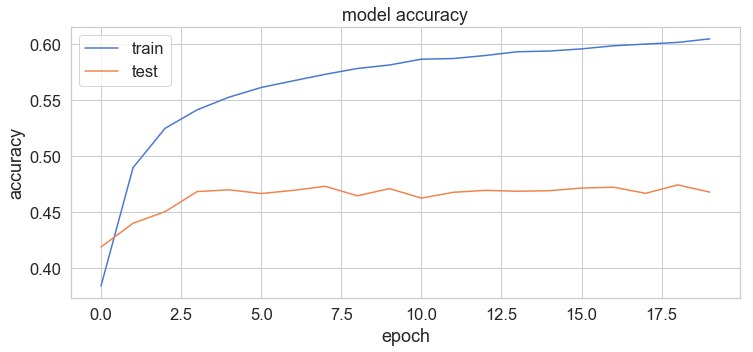

In [17]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left');

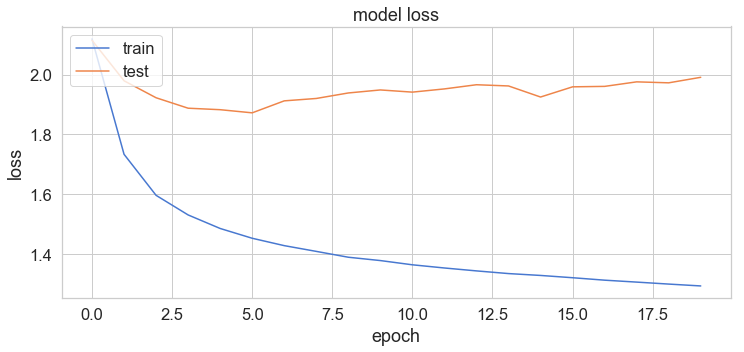

In [18]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left');

## Testing model 
Now we will predict words using our model. Design function to take input:

In [19]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

Our sequence must be 40 characters long. Tensor with shape (1, 40, 52) , initialized with zeros. Then, a value of 1 is placed for each character in the passed text.

In [20]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [21]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

The above function allows us to predict the next n most probable characters

In [22]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [23]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

Now using sequences of 40 characters that we will use as seed for our completions. All of these quotes are from Friedrich Nietzsche :

In [24]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!",
    "You only live once, but if you do it right, once is enough."
]

In [25]:
for q in quotes:
    seq=q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'all ', 'manners ', 'schopen ', 'his ']

that which does not kill us makes us str
['onger ', 'eng-development ', 'ange ', 'ives ', 'unges ']

i'm not upset that you lied to me, i'm u
['nder ', 'ponot ', 'tershes ', 'se ', 'less ']

and those who were seen dancing were tho
['se ', 'u ', 'rong! ', ' does ', 'ne ']

it is hard enough to remember my opinion
[' of ', ', ', 's, ', '\nof ', '--and ']

you only live once, but if you do it rig
['ht ', 'idically ', 'anism, ', 'orous ', 'ent ']

